In [5]:
import os
import pandas as pd
import xgboost as xgb
import numpy as np
import statsmodels as sm
from statsmodels.genmod.generalized_linear_model import GLM
from sklearn.preprocessing import OneHotEncoder
import tweedie
import seaborn as sn
import matplotlib.pyplot as plt
import warnings
#warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import pygraphviz
#warnings.filterwarnings(action='ignore', category=UserWarning)
from xgboost import plot_tree
from sklearn.utils import class_weight
import optuna
from optuna.trial import TrialState
from xgboost import plot_importance

In [6]:

class train_validate_n_test(object):

    def __init__(self) -> None:
        os.chdir('/home/optimusprime/Desktop/peeterson/github/DeepAR_demand_prediction/station_level_prediction/xgboost_forecast/data/demand_data')  
        dataset_filename = "xgboost_feat_train_ds_all_stns.csv"
        full_set = pd.read_csv(dataset_filename,parse_dates=['dt_ts'])
        full_set = full_set.drop(['Unnamed: 0'],axis=1)
        os.chdir('/home/optimusprime/Desktop/peeterson/github/DeepAR_demand_prediction/station_level_prediction/xgboost_forecast/model')

        self.train_stop_time_fold_1 = '2021/11/30 00:00'
        self.val_stop_time_fold_1 = '2021/12/05 00:00'
        self.train_stop_time_fold_2 = self.val_stop_time_fold_1
        self.val_stop_time_fold_2 = '2021/12/10 00:00'
        self.train_stop_time_fold_3 = self.val_stop_time_fold_2
        self.val_stop_time_fold_3 = '2021/12/16 00:00'

        #self.classes_weights = self.analyze_target(full_set)
        self.full_set = self.onehotencode_cat_var(full_set)


    def analyze_target(self,full_set):
        print('###################################### TARGET data EXPLORATION ###########################################')
        print('Target class frequency:')
        print(full_set['target'].value_counts())

        full_set['target'].hist()
        plt.title('Target histogram')
        plt.xlabel('demand value (class)')
        plt.ylabel('count')
        plt.show()

        classes_weights = class_weight.compute_sample_weight(class_weight='balanced',y=full_set['target'])
        print('\nTarget class weights:')
        print(np.unique(classes_weights))
        print('##########################################################################################################')
        return classes_weights


    def onehotencode_cat_var(self,full_set):
        full_set = full_set.astype({"stn_id":str,"block_id":str,"ts_of_day":str,"hr_of_day":str,"day_of_wk":str,"day_of_mn":str,"wk_of_mon":str })
        full_set = pd.get_dummies(full_set, prefix_sep="_",columns =["stn_id","block_id","ts_of_day","hr_of_day","day_of_wk","day_of_mn","wk_of_mon"],drop_first=True)
        #ds_df = ds_df.drop('rem_blk_outf_'+self.stn,axis=1)
        return full_set


    def walk_forward_val_n_train_set(self,fold):
        # split validation set into 3 parts
        if (fold==1):
            train1 = self.full_set.loc[self.full_set['dt_ts'] < self.train_stop_time_fold_1]
            tr1 = train1.drop(["target","dt_ts"], axis=1)
            label_train1 = pd.DataFrame(train1["target"])
            classes_weights = class_weight.compute_sample_weight(class_weight='balanced',y=label_train1)
            dtrain1 = xgb.DMatrix(tr1, label=label_train1,weight=classes_weights)

            print('\n',train1.isnull().values.any(),'\n')

            val1 = self.full_set.loc[(self.full_set['dt_ts'] >= self.train_stop_time_fold_1) & (self.full_set['dt_ts'] < self.val_stop_time_fold_1)]
            v1 = val1.drop(["target","dt_ts"], axis=1)
            label_val1 = pd.DataFrame(val1["target"])
            classes_weights = class_weight.compute_sample_weight(class_weight='balanced',y=label_val1)
            dval1 = xgb.DMatrix(v1, label=label_val1,weight=classes_weights)
            print('\n',val1.isnull().values.any(),'\n')

            return dtrain1, dval1
        
        elif (fold==2):
            train2 = self.full_set.loc[self.full_set['dt_ts'] < self.train_stop_time_fold_2]
            tr2 = train2.drop(["target","dt_ts"], axis=1)
            label_train2 = pd.DataFrame(train2["target"])
            classes_weights = class_weight.compute_sample_weight(class_weight='balanced',y=label_train2)
            dtrain2 = xgb.DMatrix(tr2, label=label_train2,weight=classes_weights)

            print('\n',train2.isnull().values.any(),'\n')

            val2 = self.full_set.loc[(self.full_set['dt_ts'] >= self.train_stop_time_fold_2) & (self.full_set['dt_ts'] < self.val_stop_time_fold_2)]
            v2 = val2.drop(["target","dt_ts"], axis=1)
            label_val2 = pd.DataFrame(val2["target"])
            classes_weights = class_weight.compute_sample_weight(class_weight='balanced',y=label_val2)
            dval2 = xgb.DMatrix(v2, label=label_val2,weight=classes_weights)

            print('\n',val2.isnull().values.any(),'\n')

            return dtrain2,dval2
        
        else:
            train3 = self.full_set.loc[self.full_set['dt_ts'] < self.train_stop_time_fold_3]
            tr3 = train3.drop(["target","dt_ts"], axis=1)
            label_train3 = pd.DataFrame(train3["target"])
            classes_weights = class_weight.compute_sample_weight(class_weight='balanced',y=label_train3)
            dtrain3 = xgb.DMatrix(tr3, label=label_train3,weight=classes_weights)

            print('\n',train3.isnull().values.any(),'\n')

            val3 = self.full_set.loc[(self.full_set['dt_ts'] >= self.train_stop_time_fold_3) & (self.full_set['dt_ts'] < self.val_stop_time_fold_3)]
            v3 = val3.drop(["target","dt_ts"], axis=1)
            label_val3 = pd.DataFrame(val3["target"])
            classes_weights = class_weight.compute_sample_weight(class_weight='balanced',y=label_val3)
            dval3 = xgb.DMatrix(v3, label=label_val3,weight=classes_weights)

            print('\n',val3.isnull().values.any(),'\n')

            return dtrain3,dval3



    def xgb_train_validate(self,params,num_round, e_s_r,t_v_p):
        dtrain1, dval1 = self.walk_forward_val_n_train_set(fold=1)
        watchlist1  = [(dtrain1,'train1_tweedie_loss'), (dval1, 'val1_tweedie_loss')]
        evals_result1 = {}
        model1 = xgb.train(params=params, dtrain=dtrain1, num_boost_round=num_round, evals=watchlist1, evals_result=evals_result1,  early_stopping_rounds=e_s_r,verbose_eval=False)
        val1_error = evals_result1['val1_tweedie_loss']['tweedie-nloglik@'+str(t_v_p)]

        dtrain2, dval2 = self.walk_forward_val_n_train_set(fold=2)
        watchlist2  = [(dtrain2,'train2_tweedie_loss'), (dval2, 'val2_tweedie_loss')]
        evals_result2 = {}
        model2 = xgb.train(params=params, dtrain=dtrain2, num_boost_round=num_round, evals=watchlist2, evals_result=evals_result2, early_stopping_rounds=e_s_r,xgb_model=model1,verbose_eval=False )
        val2_error = evals_result2['val2_tweedie_loss']['tweedie-nloglik@'+str(t_v_p)]

        dtrain3, dval3 = self.walk_forward_val_n_train_set(fold=3)
        watchlist3  = [(dtrain3,'train3_tweedie_loss'), (dval3, 'val3_tweedie_loss')]
        evals_result3 = {}
        self.model3 = xgb.train(params=params, dtrain=dtrain3, num_boost_round=num_round, evals=watchlist3, evals_result=evals_result3, early_stopping_rounds=e_s_r,xgb_model=model2,verbose_eval=False )
        val3_error = evals_result3['val3_tweedie_loss']['tweedie-nloglik@'+str(t_v_p)]

        print('\n')
        print('###################################### VALIDATION Loss ###########################################')
        print('Last estimator val1_error',val1_error[-1]) # Result is a list of validation loss from each of boosters/estimators, last one is final val loss.
        print('Last estimator val2_error',val2_error[-1])
        print('Last estimator val3_error',val3_error[-1])

        val_avg_error = np.mean(np.array([val1_error[-1],val2_error[-1],val3_error[-1]]))
        print('val_avg_error',val_avg_error)
        print('##################################################################################################')
        return val_avg_error


    def display_tweedie_plot(self,):
        tvs = tweedie.tweedie(mu=1, p=1.1, phi=1.5).rvs(6000)
        sn.set(rc={'figure.figsize':(10,5)})
        # plt.figure(figsize=(25,10))
        sn.displot(tvs)
        plt.title('Parametric tweedie distribution')
        plt.xlabel('demand value (class)')
        plt.show()
        return


    def evaluate_predictions(self,model):
        test = self.full_set.loc[self.full_set['dt_ts'] >= self.val_stop_time_fold_3]
        X_test = test.drop(["target","dt_ts"], axis=1)
        label_test = pd.DataFrame(test["target"])
        classes_weights = class_weight.compute_sample_weight(class_weight='balanced',y=label_test)
        dtest = xgb.DMatrix(X_test, label=label_test,weight=classes_weights)

        print('\n',test.isnull().values.any(),'\n')

        preds = model.predict(dtest)
        preds = np.rint(preds)
        label_test = label_test['target'].to_numpy()

        print('####################################### PREDICTION #################################################')    
        plt.plot(preds,'*')
        plt.ylabel('Demand value (prediction)')
        plt.xlabel('Time')     
        plt.show()
        plt.plot(label_test,'*')
        plt.ylabel('Demand value (Ground-truth)')
        plt.xlabel('Time')     
        plt.show()
        # plt.plot(label_test[40:60],'*')
        # plt.title('zoomed true label test')
        # plt.ylabel('Demand value')
        # plt.xlabel('Time')     
        # plt.show()
        # plt.plot(preds[40:60],'*')
        # plt.title('zoomed pred label')
        # plt.ylabel('Demand value')
        # plt.xlabel('Time')     
        # plt.show()

        #"use confusion matrix, ROC, F1 scores to evaluate"
        cm = confusion_matrix(label_test,preds)
        max_classes = max(len(np.unique(label_test)),len(np.unique(preds)))
        df_cm = pd.DataFrame(cm, index = [i for i in range(max_classes)],
                        columns = [i for i in range(max_classes)])
        plt.figure(figsize = (10,7))      
        s = sn.heatmap(df_cm, annot=True, )
        s.set(xlabel='Predicted-Label', ylabel='True-Label')
        print('##################################################################################################')

        return X_test,label_test, preds


    def identify_tweedie_variance_param():
        #TODO:#"fit on data"
        # follow this tutorial https://notebook.community/thequackdaddy/tweedie/example/tweedie_demo
        # GLM.estimate_tweedie_power()
        # #Training model
        # tweedie_model = sm.GLM(y_train, X_train, exposure = df_train.exposure, family=sm.families.Tweedie(link=None,var_power=1.5,eql=True))
        # tweedie_result = tweedie_model.fit()
        # #Using the initial model output to decide the optimum index parameter "p"
        # GLM.estimate_tweedie_power(training_result, method='brentq', low=1.01, high=5.0)
        # tweedie_model.estimate_tweedie_power(tweedie_result.mu, method='brentq', low=1.01, high=5.0)
        return


    def make_predictions(self,best_params,num_round, e_s_r):
        #TODO:#for new predictions after tuning model
        train4 = self.full_set.loc[self.full_set['dt_ts'] < self.val_stop_time_fold_3]
        tr4 = train4.drop(["target","dt_ts"], axis=1)
        label_train4 = pd.DataFrame(train4["target"])
        classes_weights = class_weight.compute_sample_weight(class_weight='balanced',y=label_train4)
        dtrain4 = xgb.DMatrix(tr4, label=label_train4,weight=classes_weights)

        watchlist4  = [(dtrain4,'train4_tweedie_loss')]
        evals_result4 = {}
        self.model4 = xgb.train(params=best_params, dtrain=dtrain4, num_boost_round=num_round, evals=watchlist4, evals_result=evals_result4, early_stopping_rounds=e_s_r,verbose_eval=False )
        return self.model4 # best_model
    

    def visualize_tree(self,):
        #TODO:#"draw out a few trees to interpret results"        
        #xgb.plot_tree(self.train3)
        plot_tree(self.model4)

        return



In [7]:

def objective(trial):
 
    #os.chdir("c:\Work\WORK_PACKAGE\Demand_forecasting\BLUESG_Demand_data\Data-preprocessing_data_generation")
    t_v_t = train_validate_n_test()

    tweedie_variance_power = round(trial.suggest_float(name='tweedie_variance_power',low=1.1,high=1.9,step=0.1,log=False),1)

    ######  SET Hyperparameter's range for tuning ######
    early_stopping_rounds = 30
    eval_metric = 'tweedie-nloglik@'+str(tweedie_variance_power)
    num_round= 1000
    # Hyperparameters and algorithm parameters are described here
    params = {"max_depth": trial.suggest_int('max_depth', 3, 10),
            "eta": trial.suggest_float(name='eta', low=0.0001, high=0.1,log=True),
            "subsample" : round(trial.suggest_float(name='subsample', low=0.1, high=1.0,step=0.1),1),
            "colsample_bytree": round(trial.suggest_float(name='colsample_bytree', low=0.1, high=1.0,step=0.1),1),
            'eval_metric':eval_metric, ## try using AUC as well.. 
            'tweedie_variance_power': tweedie_variance_power,
            'gamma': trial.suggest_int('gamma', 0, 5),
            'reg_alpha': trial.suggest_int('reg_alpha', 0, 5), 
            'reg_lambda': trial.suggest_int('reg_lambda', 0, 5),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            "objective": 'reg:tweedie',
            'gpu_id': 0,
            "tree_method": 'gpu_hist',
            }
    ######  SET Hyperparameter's range for tuning ######

    val_avg_error = t_v_t.xgb_train_validate(params,num_round, early_stopping_rounds,tweedie_variance_power)
    return val_avg_error

In [8]:

if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, timeout=12000, n_trials=500)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    #print("Best hyperparameters:", study.best_params)

    fig = optuna.visualization.plot_parallel_coordinate(study)
    fig.show()

    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

    fig = optuna.visualization.plot_slice(study)
    fig.show()

    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

    best_tweedie_variance_power = study.best_params["tweedie_variance_power"]
    best_params = {"max_depth": study.best_params["max_depth"],
            "eta": study.best_params["eta"],
            "subsample" : study.best_params["subsample"],
            "colsample_bytree": study.best_params["colsample_bytree"],
            'eval_metric':'tweedie-nloglik@'+str(best_tweedie_variance_power), ## try using AUC as well.. 
            'tweedie_variance_power': best_tweedie_variance_power,
            'gamma': study.best_params["gamma"],
            'reg_alpha': study.best_params["reg_alpha"], 
            'reg_lambda': study.best_params["reg_lambda"],
            'min_child_weight': study.best_params["min_child_weight"],
            "objective": 'reg:tweedie',
            }
    early_stopping_rounds = 30
    eval_metric = 'tweedie-nloglik@'+str(best_tweedie_variance_power)
    num_round= 1000

    t_v_t = train_validate_n_test()
    best_model = t_v_t.make_predictions(best_params,num_round, early_stopping_rounds)
    t_v_t.evaluate_predictions(best_model)

    plot_importance(best_model)
    plt.show()

    # t_v_t.display_tweedie_plot() # compare the graphs from target histogram and this function to choose tweedie_variance_power 
    # X_test,label_test, preds = t_v_t.evaluate_predictions()
    # t_v_t.visualize_tree()
    # # print('\n',"tweedie_variance_power ",tweedie_variance_power,'\n')

[I 2023-04-17 11:39:13,910] A new study created in memory with name: no-name-46c5df96-0470-4016-b3e4-91e5bb6edb46



 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-17 11:39:18,923] Trial 0 finished with value: 14.615800672286879 and parameters: {'tweedie_variance_power': 1.1, 'max_depth': 7, 'learning_rate': 0.00011086880016066307, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.2, 'gamma': 3, 'reg_alpha': 5, 'reg_lambda': 2, 'min_child_weight': 8}. Best is trial 0 with value: 14.615800672286879.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 16.48680488485482
Last estimator val2_error 11.147762636551867
Last estimator val3_error 16.212834495453947
val_avg_error 14.615800672286879
##################################################################################################

 False 


 False 


 False 


 False 



[I 2023-04-17 11:39:20,471] Trial 1 finished with value: 5.65888556853102 and parameters: {'tweedie_variance_power': 1.8000000000000003, 'max_depth': 4, 'learning_rate': 0.006478015903864794, 'subsample': 0.4, 'colsample_bytree': 0.4, 'gamma': 4, 'reg_alpha': 2, 'reg_lambda': 3, 'min_child_weight': 8}. Best is trial 1 with value: 5.65888556853102.



 False 


 False 



###################################### VALIDATION Loss ###########################################
Last estimator val1_error 5.901927964187817
Last estimator val2_error 5.185869724651524
Last estimator val3_error 5.888859016753719
val_avg_error 5.65888556853102
##################################################################################################

 False 


 False 


 False 


 False 



[I 2023-04-17 11:39:22,435] Trial 2 finished with value: 4.506351147560967 and parameters: {'tweedie_variance_power': 1.4000000000000001, 'max_depth': 8, 'learning_rate': 0.006935045838772195, 'subsample': 0.8, 'colsample_bytree': 0.7000000000000001, 'gamma': 3, 'reg_alpha': 1, 'reg_lambda': 3, 'min_child_weight': 1}. Best is trial 2 with value: 4.506351147560967.



 False 


 False 



###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.9125804543762595
Last estimator val2_error 3.713947874439793
Last estimator val3_error 4.892525113866849
val_avg_error 4.506351147560967
##################################################################################################

 False 


 False 


 False 


 False 



[I 2023-04-17 11:39:23,570] Trial 3 finished with value: 7.496189455716224 and parameters: {'tweedie_variance_power': 1.2000000000000002, 'max_depth': 4, 'learning_rate': 0.010846344061152107, 'subsample': 0.1, 'colsample_bytree': 0.30000000000000004, 'gamma': 3, 'reg_alpha': 3, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 2 with value: 4.506351147560967.



 False 


 False 



###################################### VALIDATION Loss ###########################################
Last estimator val1_error 8.33877210735863
Last estimator val2_error 5.9026517971671
Last estimator val3_error 8.247144462622947
val_avg_error 7.496189455716224
##################################################################################################

 False 


 False 


 False 


 False 



[I 2023-04-17 11:39:24,375] Trial 4 finished with value: 5.641976551867059 and parameters: {'tweedie_variance_power': 1.8000000000000003, 'max_depth': 5, 'learning_rate': 0.03001379039695659, 'subsample': 0.6, 'colsample_bytree': 0.4, 'gamma': 3, 'reg_alpha': 2, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 2 with value: 4.506351147560967.



 False 


 False 



###################################### VALIDATION Loss ###########################################
Last estimator val1_error 5.881727604811018
Last estimator val2_error 5.155527046512989
Last estimator val3_error 5.888675004277169
val_avg_error 5.641976551867059
##################################################################################################

 False 


 False 



[I 2023-04-17 11:39:24,875] Trial 5 finished with value: 5.414455206908656 and parameters: {'tweedie_variance_power': 1.3, 'max_depth': 6, 'learning_rate': 0.051188542833309494, 'subsample': 0.2, 'colsample_bytree': 0.4, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 1, 'min_child_weight': 1}. Best is trial 2 with value: 4.506351147560967.



 False 


 False 


 False 


 False 



###################################### VALIDATION Loss ###########################################
Last estimator val1_error 5.982340073724126
Last estimator val2_error 4.364155331822654
Last estimator val3_error 5.896870215179188
val_avg_error 5.414455206908656
##################################################################################################

 False 


 False 


 False 


 False 



[I 2023-04-17 11:39:25,339] Trial 6 finished with value: 9.712264424365916 and parameters: {'tweedie_variance_power': 1.9, 'max_depth': 4, 'learning_rate': 0.07681441134158291, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.7000000000000001, 'gamma': 2, 'reg_alpha': 3, 'reg_lambda': 1, 'min_child_weight': 9}. Best is trial 2 with value: 4.506351147560967.



 False 


 False 



###################################### VALIDATION Loss ###########################################
Last estimator val1_error 9.99473580541331
Last estimator val2_error 9.109452384589822
Last estimator val3_error 10.032605083094616
val_avg_error 9.712264424365916
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[W 2023-04-17 11:39:29,635] Trial 7 failed with parameters: {'tweedie_variance_power': 1.6, 'max_depth': 6, 'learning_rate': 0.00010638043537822504, 'subsample': 0.9, 'colsample_bytree': 0.30000000000000004, 'gamma': 2, 'reg_alpha': 0, 'reg_lambda': 0, 'min_child_weight': 5} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/optimusprime/miniconda3/envs/test-xgb/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_58748/30324960.py", line 29, in objective
    val_avg_error = t_v_t.xgb_train_validate(params,num_round, early_stopping_rounds,tweedie_variance_power)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_58748/2942198347.py", line 122, in xgb_train_validate
    self.model3 = xgb.train(params=params, dtrain=dtrain3, num_boost_round=

KeyboardInterrupt: 


 False 

####################################### PREDICTION #################################################


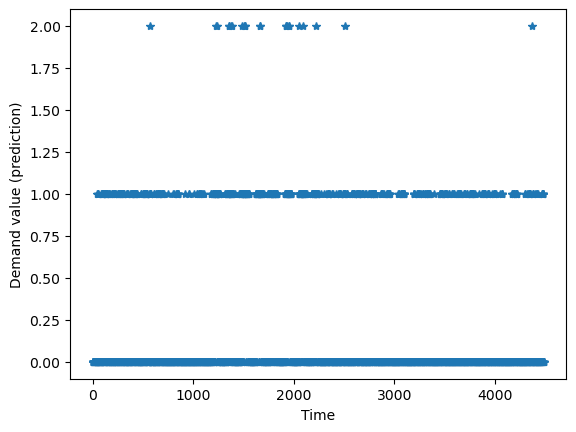

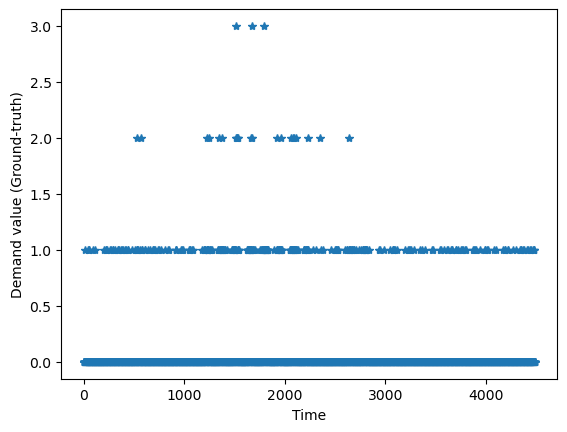

##################################################################################################


(       rem_blk_outf  net_inflow_stn  en_route_inf  net_inflow_clstr_10_min  \
 8928            0.0               1           0.0                      0.0   
 8929            0.0               1           0.0                      0.0   
 8930            0.0               0           0.0                      0.0   
 8931            0.0               0           0.0                      0.0   
 8932            0.0              -1           0.0                      0.0   
 ...             ...             ...           ...                      ...   
 40195           1.0               1           0.0                      1.0   
 40196           0.0               1           1.0                      1.0   
 40197           0.0               2           0.0                      1.0   
 40198           0.0               2           2.0                      1.0   
 40199           0.0               4           0.0                      1.0   
 
        DeepAR_agg_outflow  p_1wk_o  p_2wk_o  p_3w

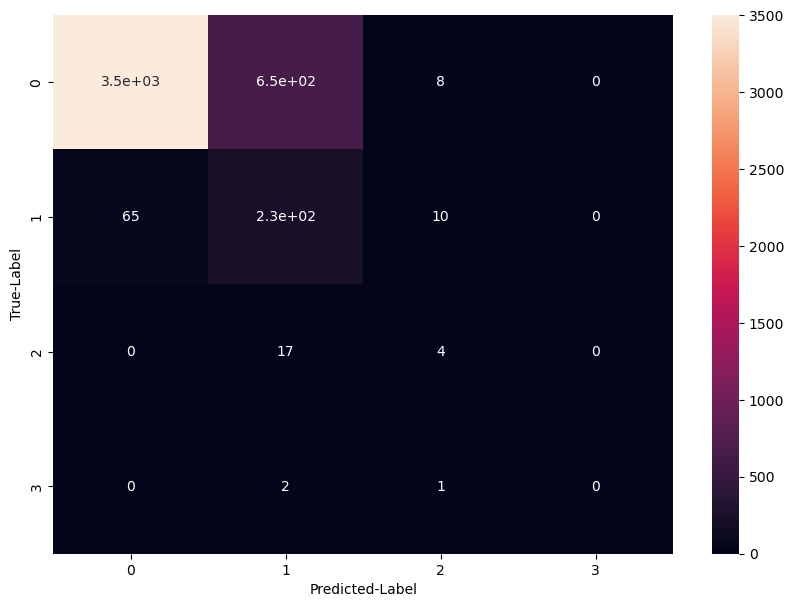

In [9]:

best_tweedie_variance_power = study.best_params["tweedie_variance_power"]
best_params = {"max_depth": study.best_params["max_depth"],
        "eta": 0.1,
        "subsample" : study.best_params["subsample"],
        "colsample_bytree": study.best_params["colsample_bytree"],
        'eval_metric':'tweedie-nloglik@'+str(best_tweedie_variance_power), ## try using AUC as well.. 
        'tweedie_variance_power': best_tweedie_variance_power,
        'gamma': study.best_params["gamma"],
        'reg_alpha': study.best_params["reg_alpha"], 
        'reg_lambda': study.best_params["reg_lambda"],
        'min_child_weight': study.best_params["min_child_weight"],
        "objective": 'reg:tweedie',
        }
early_stopping_rounds = 30
eval_metric = 'tweedie-nloglik@'+str(best_tweedie_variance_power)
num_round= 1000

t_v_t = train_validate_n_test()
best_model = t_v_t.make_predictions(best_params,num_round, early_stopping_rounds)
t_v_t.evaluate_predictions(best_model)

In [ ]:
best_tweedie_variance_power = study.best_params["tweedie_variance_power"]
best_params = {"max_depth": study.best_params["max_depth"],
        "eta": 0.01,
        "subsample" : study.best_params["subsample"],
        "colsample_bytree": study.best_params["colsample_bytree"],
        'eval_metric':'tweedie-nloglik@'+str(best_tweedie_variance_power), ## try using AUC as well.. 
        'tweedie_variance_power': best_tweedie_variance_power,
        'gamma': study.best_params["gamma"],
        'reg_alpha': study.best_params["reg_alpha"], 
        'reg_lambda': study.best_params["reg_lambda"],
        'min_child_weight': study.best_params["min_child_weight"],
        "objective": 'reg:tweedie',
        }
early_stopping_rounds = 30
eval_metric = 'tweedie-nloglik@'+str(best_tweedie_variance_power)
num_round= 1000

t_v_t = train_validate_n_test()
best_model = t_v_t.make_predictions(best_params,num_round, early_stopping_rounds)
t_v_t.evaluate_predictions(best_model)

: 

In [ ]:
best_tweedie_variance_power = study.best_params["tweedie_variance_power"]
best_params = {"max_depth": study.best_params["max_depth"],
        "eta": 0.001,
        "subsample" : study.best_params["subsample"],
        "colsample_bytree": study.best_params["colsample_bytree"],
        'eval_metric':'tweedie-nloglik@'+str(best_tweedie_variance_power), ## try using AUC as well.. 
        'tweedie_variance_power': best_tweedie_variance_power,
        'gamma': study.best_params["gamma"],
        'reg_alpha': study.best_params["reg_alpha"], 
        'reg_lambda': study.best_params["reg_lambda"],
        'min_child_weight': study.best_params["min_child_weight"],
        "objective": 'reg:tweedie',
        }
early_stopping_rounds = 30
eval_metric = 'tweedie-nloglik@'+str(best_tweedie_variance_power)
num_round= 1000

t_v_t = train_validate_n_test()
best_model = t_v_t.make_predictions(best_params,num_round, early_stopping_rounds)
t_v_t.evaluate_predictions(best_model)

: 

In [ ]:
best_tweedie_variance_power = study.best_params["tweedie_variance_power"]
best_params = {"max_depth": study.best_params["max_depth"],
        "eta": 0.0001,
        "subsample" : study.best_params["subsample"],
        "colsample_bytree": study.best_params["colsample_bytree"],
        'eval_metric':'tweedie-nloglik@'+str(best_tweedie_variance_power), ## try using AUC as well.. 
        'tweedie_variance_power': best_tweedie_variance_power,
        'gamma': study.best_params["gamma"],
        'reg_alpha': study.best_params["reg_alpha"], 
        'reg_lambda': study.best_params["reg_lambda"],
        'min_child_weight': study.best_params["min_child_weight"],
        "objective": 'reg:tweedie',
        }
early_stopping_rounds = 30
eval_metric = 'tweedie-nloglik@'+str(best_tweedie_variance_power)
num_round= 1000

t_v_t = train_validate_n_test()
best_model = t_v_t.make_predictions(best_params,num_round, early_stopping_rounds)
t_v_t.evaluate_predictions(best_model)

: 

In [ ]:
best_tweedie_variance_power = study.best_params["tweedie_variance_power"]
best_params = {"max_depth": study.best_params["max_depth"],
        "eta": 0.00001,
        "subsample" : study.best_params["subsample"],
        "colsample_bytree": study.best_params["colsample_bytree"],
        'eval_metric':'tweedie-nloglik@'+str(best_tweedie_variance_power), ## try using AUC as well.. 
        'tweedie_variance_power': best_tweedie_variance_power,
        'gamma': study.best_params["gamma"],
        'reg_alpha': study.best_params["reg_alpha"], 
        'reg_lambda': study.best_params["reg_lambda"],
        'min_child_weight': study.best_params["min_child_weight"],
        "objective": 'reg:tweedie',
        }
early_stopping_rounds = 30
eval_metric = 'tweedie-nloglik@'+str(best_tweedie_variance_power)
num_round= 1000

t_v_t = train_validate_n_test()
best_model = t_v_t.make_predictions(best_params,num_round, early_stopping_rounds)
t_v_t.evaluate_predictions(best_model)

: 